# Assignment - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student.

In [ ]:
# student details 1: Anna P. 2148
# student details 2: Almog S. 0824

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name: ChatGPT (OpenAI GPT-5)

Goal: Understand cross-validation and grid search
Prompt1: "How does cross-validation help in choosing the best configuration of the model?"
Prompt2: "Why should we test several model configurations, and what is the advantage of choosing the one with the smallest C when multiple have the same F1 score?"

Goal: Understand solver selection considerations
Prompt1: "Why is liblinear better for small datasets?"
Prompt2: "Does the solver affect the training process itself, or only the speed of training?"
Prompt3: "Why is l2 penalty the default, and when should l1 be used instead?"

Goal: Understand the role of solver and penalty
Prompt1: "What is the difference between penalty and solver?"
Prompt2: "Is it necessary to set the solver in the code if C and penalty are already chosen?"
Prompt3: "Why do we need to choose a specific solver in Logistic Regression, and what is the difference between liblinear and lbfgs?"

Other assistanse: Class lecture slides.
</pre>

## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

#### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>
In this project, we used the Titanic dataset to build a machine learning model that predicts passenger survival.
We first explored the data and created visualizations to see how features like age, sex, and passenger class relate to survival.
Then, we trained a Logistic Regression model and tested different settings such as penalties, regularization, and scaling.
Using 5-fold cross validation with the F1 score, we chose the best setup, retrained the model on all the training data, and finally tested it on new data to check its performance.
</pre>

### Part 2 - Initial Preparations
We loaded the train and test datasets.

We showed the first 5 rows for each dataset (train and test) and created 3 visualizations:
1. survival by passenger class
2. age distribution by survival
3. age boxplot

We also made a table of survival rates by gender.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# --- Load datasets ---
train_df = pd.read_csv("/titanic_train.csv")
test_df = pd.read_csv("/titanic_test.csv")

# Map numeric columns to readable labels
train_df["Sex"] = train_df["Sex"].map({0: "male", 1: "female"})
test_df["Sex"] = test_df["Sex"].map({0: "male", 1: "female"})
train_df["Embarked"] = train_df["Embarked"].map({0: "Cherbourg", 1: "Queenstown", 2: "Southampton"})

# Show first 5 rows from each dataset
print("Train – first 5 rows:")
print(train_df.head())
print("\nTest – first 5 rows:")
print(test_df.head())

Train – first 5 rows:
   Pclass     Sex   Age  SibSp  Parch     Fare    Embarked  Survived
0       1    male  54.0      1      0  78.2667  Queenstown         1
1       2    male  45.0      0      0  13.5000   Cherbourg         1
2       3  female  20.0      0      0   9.5000   Cherbourg         0
3       3  female  36.0      0      0   7.8958   Cherbourg         0
4       3  female  22.0      0      0   8.0500   Cherbourg         0

Test – first 5 rows:
   Pclass     Sex        Age  SibSp  Parch     Fare  Embarked  Survived
0       3  female  35.000000      0      0   7.0500         0         0
1       3  female  30.000000      0      0   7.2500         0         0
2       3  female  29.699118      0      0  14.5000         0         0
3       3    male  21.000000      0      0   7.7500         2         0
4       3  female  32.000000      0      0  56.4958         0         1


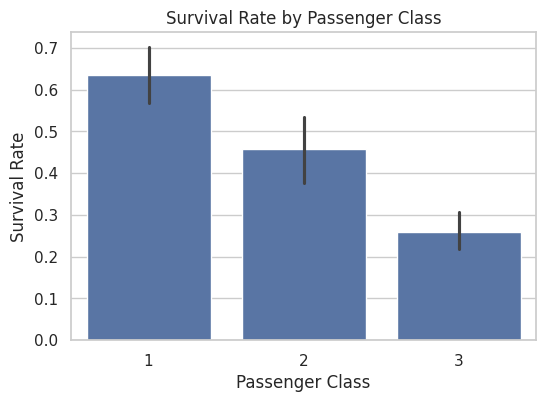

Passengers in higher classes (1st class) had higher survival rates.


In [ ]:
# Set seaborn style
sns.set(style="whitegrid")

# --- Visualization 1: Survival by Passenger Class ---
plt.figure(figsize=(6, 4))
sns.barplot(x="Pclass", y="Survived", data=train_df)
plt.title("Survival Rate by Passenger Class")
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.show()
print("Passengers in higher classes (1st class) had higher survival rates.")

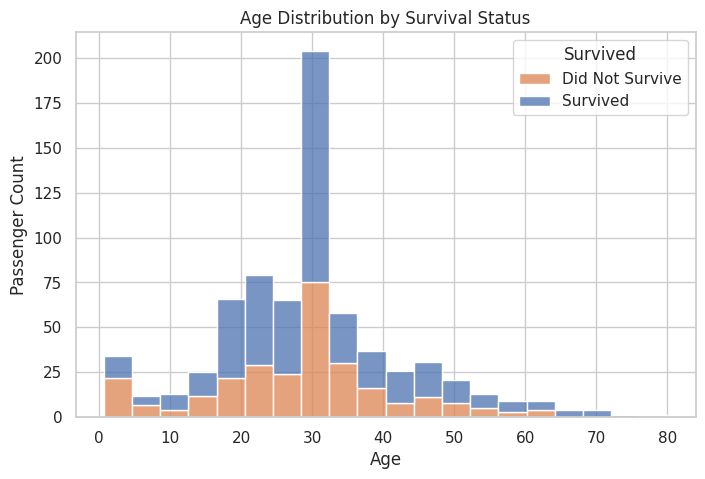

Younger passengers had slightly better survival rates compared to older ones.


In [ ]:
# --- Visualization 2: Age distribution by survival status ---
plt.figure(figsize=(8, 5))
sns.histplot(data=train_df, x="Age", hue="Survived", multiple="stack", bins=20)
plt.title("Age Distribution by Survival Status")
plt.xlabel("Age")
plt.ylabel("Passenger Count")
plt.legend(title="Survived", labels=["Did Not Survive", "Survived"])
plt.show()
print("Younger passengers had slightly better survival rates compared to older ones.")


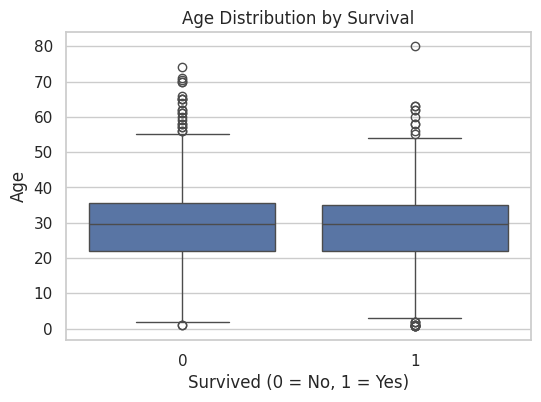

Median age of survivors was lower than non-survivors, but with overlap.


In [ ]:
# --- Visualization 3: Box plot of Age by Survival ---
plt.figure(figsize=(6, 4))
sns.boxplot(x="Survived", y="Age", data=train_df)
plt.title("Age Distribution by Survival")
plt.xlabel("Survived (0 = No, 1 = Yes)")
plt.ylabel("Age")
plt.show()
print("Median age of survivors was lower than non-survivors, but with overlap.")


In [ ]:
# --- Table: Survival rate by Sex ---
sex_survival = (
    train_df.groupby("Sex")["Survived"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "Survival_Rate", "count": "Count"})
)
sex_survival["Survival_Rate"] = sex_survival["Survival_Rate"].round(2)

print("\nSurvival rate by Sex:")
print(sex_survival)


Survival rate by Sex:
      Sex  Survival_Rate  Count
0  female           0.19    456
1    male           0.75    256


## Part 3 - Experiments
We used Logistic Regression as our model.

We tested feature scaling (on/off), different penalties (l1, l2), and different regularization values (C = 0.1, 1, 10).

We applied 5-fold cross validation and measured model quality with the F1 score.

We selected the best configuration based on the highest F1 (and smaller C if equal, to reduce overfitting and prefer a simpler model).

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

In [ ]:
# Convert encoded values to readable labels
train_df["Embarked"] = train_df["Embarked"].map({0: "Cherbourg", 1: "Queenstown", 2: "Southampton"})
test_df["Embarked"] = test_df["Embarked"].map({0: "Cherbourg", 1: "Queenstown", 2: "Southampton"})

# Select features
numeric_features = ["Age", "Fare", "SibSp", "Parch"]
categorical_features = ["Pclass", "Sex", "Embarked"]
features = numeric_features + categorical_features

# One-hot encode categorical features
X_train = pd.get_dummies(train_df[features])
X_test = pd.get_dummies(test_df[features])

# Align train and test (ensure same columns)
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

y_train = train_df["Survived"]
y_test = test_df["Survived"]

In [ ]:
def run_logistic_regression_kfold(X, y, is_scaled, results):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Hyperparameter grid
    C_list = [0.1, 1, 10]
    penalty_list = ['l1', 'l2']

    for C in C_list:
        for penalty in penalty_list:
            f1_scores = []

            for train_idx, val_idx in kf.split(X):
                X_train_fold, X_val_fold = X.iloc[train_idx].copy(), X.iloc[val_idx].copy()
                y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

                # Apply scaling
                if is_scaled:
                    scaler = StandardScaler()
                    X_train_fold[numeric_features] = scaler.fit_transform(X_train_fold[numeric_features])
                    X_val_fold[numeric_features] = scaler.transform(X_val_fold[numeric_features])

                # Train Logistic Regression
                lr = LogisticRegression(
                    C=C,
                    penalty=penalty,
                    solver='liblinear',
                    max_iter=1000,
                    random_state=42
                )
                lr.fit(X_train_fold, y_train_fold)
                y_pred = lr.predict(X_val_fold)
                f1 = f1_score(y_val_fold, y_pred)
                f1_scores.append(f1)

            # Save average F1 score over all folds
            results.append({
                "Scaling": is_scaled,
                "C": C,
                "Penalty": penalty,
                "F1 Score Mean": round(sum(f1_scores) / len(f1_scores), 3)
            })

# Run experiments with and without scaling
results = []
run_logistic_regression_kfold(X_train, y_train, is_scaled=True, results=results)
run_logistic_regression_kfold(X_train, y_train, is_scaled=False, results=results)

results_df = pd.DataFrame(results)

# Show all configurations sorted by F1 and C
print("\nGrid Search Results (average F1 per configuration):")
print(results_df.sort_values(by=["F1 Score Mean", "C"], ascending=[False, True]))

# Select best configuration: max F1, prefer lower C if equal
best_config = results_df.sort_values(
    by=["F1 Score Mean", "C"],
    ascending=[False, True]
).iloc[0]

print("\nBest Configuration:")
print(best_config)



Grid Search Results (average F1 per configuration):
    Scaling     C Penalty  F1 Score Mean
6     False   0.1      l1          0.726
11    False  10.0      l2          0.726
0      True   0.1      l1          0.724
4      True  10.0      l1          0.723
5      True  10.0      l2          0.723
10    False  10.0      l1          0.723
1      True   0.1      l2          0.720
3      True   1.0      l2          0.719
9     False   1.0      l2          0.719
7     False   0.1      l2          0.718
2      True   1.0      l1          0.718
8     False   1.0      l1          0.718

Best Configuration:
Scaling          False
C                  0.1
Penalty             l1
F1 Score Mean    0.726
Name: 6, dtype: object


## Part 4 - Training
We trained the Logistic Regression model again on the entire training set using the best configuration from Part 3.

This step gives us the final model that we will use for predictions.

In [ ]:
# Extract best configuration
best_scaling = best_config["Scaling"]
best_C = best_config["C"]
best_penalty = best_config["Penalty"]

# Make a copy of the full training data
X_final = X_train.copy()
y_final = y_train.copy()

# Apply scaling
if best_scaling:
    final_scaler = StandardScaler()
    X_final[numeric_features] = final_scaler.fit_transform(X_final[numeric_features])

# Train the final model on the entire training set
final_model = LogisticRegression(
    C=best_C,
    penalty=best_penalty,
    solver="liblinear",
    max_iter=1000,
    random_state=42
)

final_model.fit(X_final, y_final)

print("Final model trained on full training set:")
print(f"Scaling: {best_scaling}, C: {best_C}, Penalty: {best_penalty}")


Final model trained on full training set:
Scaling: False, C: 0.1, Penalty: l1


## Part 5 - Apply on test and show model performance estimation

The test set is new data that the model has not seen before.

We applied the same preprocessing as in training and used the final model to predict survival.

We showed the first 5 predictions and calculated the F1 score on the test set to evaluate model performance.

In [ ]:
# Prepare test data
X_test_final = X_test.copy()
y_test_final = y_test

# Apply scaling (same scaler as training)
if best_config["Scaling"]:
    scaler = StandardScaler()
    X_final = X_train.copy()
    X_final[numeric_features] = scaler.fit_transform(X_final[numeric_features])
    X_test_final[numeric_features] = scaler.transform(X_test_final[numeric_features])
else:
    X_final = X_train.copy()

# Retrain the model on full training set with best configuration
final_model = LogisticRegression(
    C=best_config["C"],
    penalty=best_config["Penalty"],
    solver="liblinear",
    max_iter=1000,
    random_state=42
).fit(X_final, y_train)

# Predict on test set
y_test_pred = final_model.predict(X_test_final)

# Show first 5 predictions
print("First 5 predictions on test set:")
print(y_test_pred[:5])

# Evaluate F1 score on test set
f1_test = f1_score(y_test_final, y_test_pred)
print(f"\nF1 Score on Test Set: {f1_test:.4f}")


First 5 predictions on test set:
[0 0 0 1 0]

F1 Score on Test Set: 0.6721
